In [ ]:
!pip install kaggle

In [1]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [4]:
import tensorflow as tf
# import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

# tf.enable_eager_execution()

tf.__version__

'2.0.0-alpha0'

# Get all the files

In [ ]:
import os

def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file

        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see:"
                             "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()                

In [ ]:
import kaggle

# Download data from Kaggle

In [5]:
competition_name = 'carvana-image-masking-challenge'

In [ ]:
def load_data_from_zip(competition, file):
    with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(competition)
        
def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

get_data(competition_name)

In [6]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [7]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [8]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [9]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [10]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [ ]:
x_train_filenames[:10]

In [ ]:
y_train_filenames[:10]

# Visualize

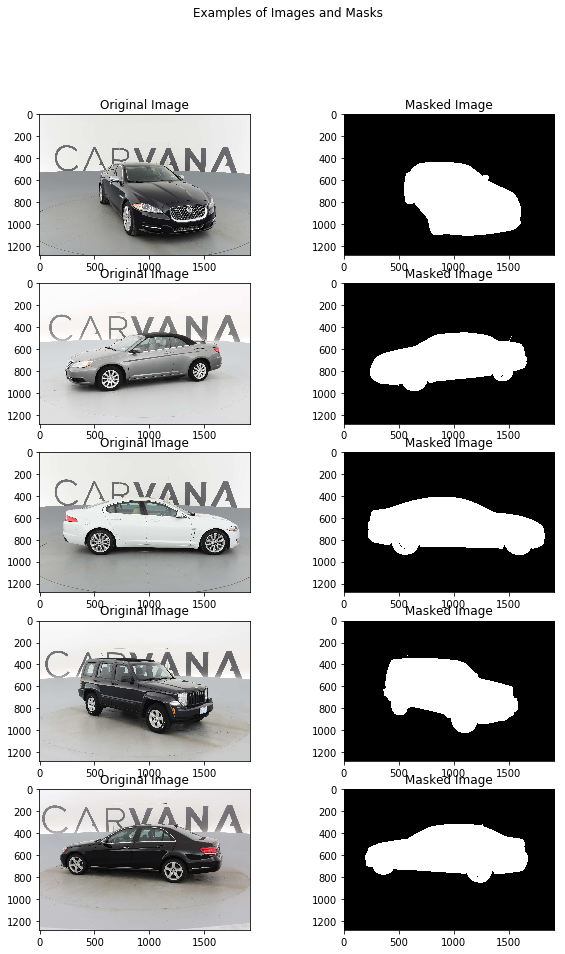

In [9]:
display_num = 5

r_choice = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num*2, 2):
    idx = i // 2
    x_path = x_train_filenames[idx]
    y_path = y_train_filenames[idx]
    
    plt.subplot(display_num, 2, i+1)
    plt.imshow(plt.imread(x_path))
    plt.title("Original Image")
    
    plt.subplot(display_num, 2, i+2)
    plt.imshow(plt.imread(y_path))
    plt.title("Masked Image")
    
#     example_labels = Image.open(y_path)
#     label_vals = np.unique(example_labels)  
#     plt.subplot(display_num, 2, i + 2)
#     plt.imshow(example_labels)
#     plt.title("Masked Image") 

plt.suptitle("Examples of Images and Masks")
plt.show()


# Set up

In [11]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

# Build the input pipeline

## Convert each file name to image

In [16]:
def _process_pathnames(fname, label_path):
    """Convet input file name amd label path into image and mask."""
    img = tf.image.decode_jpeg(tf.io.read_file(fname), channels=3)
    label_img = tf.image.decode_gif(tf.io.read_file(label_path))[0]
    label_img = tf.expand_dims(label_img[:,:,0], axis=-1)
    return img, label_img

(1280, 1918, 3) (1280, 1918, 1)


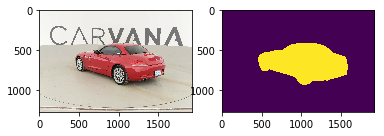

In [17]:
img, mask = _process_pathnames(x_train_filenames[5], y_train_filenames[5])

print(img.shape, mask.shape)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])


## Shifting the image

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(tfcontrib.image.translate(img, [500, 500]))

In [21]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        # randomly select a number from [-shift, shift]
        if width_shift_range:
            width_shift_range = tf.random.uniform([], minval=-img_shape[1]*width_shift_range,
                                                 maxval=img_shape[1]*width_shift_range)
            
        if height_shift_range:
            height_shift_range = tf.random.uniform([], minval=-img_shape[0]*height_shift_range,
                                                 maxval=img_shape[0]*height_shift_range)
            
#         output_img = tfcontrib.image.translate(output_img, [width_shift_range, height_shift_range])
#         label_img = tfcontrib.image.translate(label_img, [width_shift_range, height_shift_range])
        
        w = output_img.shape[1]
        h = output_img.shape[0]
        output_img = tf.image.crop_to_bounding_box(output_img, 
                                                   height_shift_range, width_shift_range,
                                                   h, w)
        label_img = tf.image.crop_to_bounding_box(label_img, 
                                                  height_shift_range, width_shift_range,
                                                  h, w)
        
    return output_img, label_img
    

In [22]:
img2, mask2 = shift_img(tf.image.resize(img, img_shape[:-1]), tf.image.resize(mask, img_shape[:-1]), 0.5, 0.5)

plt.subplot(1,2,1)
plt.imshow(img2/255)
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'offset_width must be >= 0.'

## Flipping the image randomly

In [25]:
def flip_img(horizontal_flip, tr_img, label_img):
    """Flip the image and mask at the probability of 0.5"""    
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
        
#         to_flip = tf.random_uniform([], 0.0, 1.0).numpy() > 0.5

#         if to_flip:
#             tr_img = tf.image.flip_left_right(tr_img)
#             label_img = tf.image.flip_left_right(label_img)
        
    return tr_img, label_img
    
    

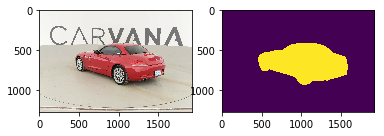

In [27]:
img2, mask2 = flip_img(True, img, mask)

plt.subplot(1,2,1)
plt.imshow(img2)
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

## Assemble into the augment function

In [30]:
def _augment(img, label_img,
             resize=None,
             scale=1,
             hue_delta=0,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0):
    if resize is not None:
        # resize both image and mask
        img = tf.image.resize(img, resize)
        label_img = tf.image.resize(label_img, resize)
        
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
        
        
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    
    img = tf.cast(img, tf.float32) * scale
    label_img = tf.cast(label_img, tf.float32) * scale
    
    return img, label_img

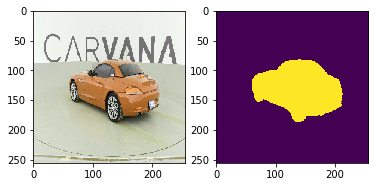

In [35]:
img2, mask2 = _augment(img, mask, resize=img_shape[:-1], scale=1/255.0, hue_delta=0.2, horizontal_flip=True,
                      width_shift_range=0, height_shift_range=0)

plt.subplot(1,2,1)
plt.imshow(img2)
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

In [36]:
def get_baseline_dataset(filenames, labels, preproc_fn=functools.partial(_augment),
                         threads=5, batch_size=batch_size, shuffle=True):
    """Create a TF Dataset from filenames"""
    num_x = len(filenames)
    
    # 1. Create a dataset of filenames
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # 2. Convert filenames into images
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    
    # 3. Augment data
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, """Batching images must be of the same size"""
        
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    
    if shuffle:
        dataset.shuffle(num_x)
        
    return dataset.repeat().batch(batch_size)
    

## Set up training and validation datasets

In [37]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1/255.0,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0,
    'height_shift_range': 0    
}

tr_preproc_fn = functools.partial(_augment, **tr_cfg)

In [38]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1/255.0,
}
val_preproc_fn = functools.partial(_augment, **val_cfg)

In [39]:
train_ds = get_baseline_dataset(x_train_filenames, y_train_filenames, preproc_fn=tr_preproc_fn, batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames, y_val_filenames, preproc_fn=val_preproc_fn, batch_size=batch_size)

## Check the input pipeline

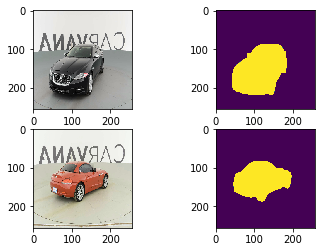

In [40]:
temp_ds = get_baseline_dataset(x_train_filenames, y_train_filenames, preproc_fn=tr_preproc_fn,
                              batch_size=1, shuffle=False)
n_x = len(x_train_filenames)
for i, x in enumerate(temp_ds.take(6)):
    if i is 0:        
        plt.subplot(2,2,1)
        plt.imshow(x[0][0,:,:,:])
        plt.subplot(2,2,2)
        plt.imshow(x[1][0,:,:,0])
        
    if i is 5:
        plt.subplot(2,2,3)
        plt.imshow(x[0][0,:,:,:])
        plt.subplot(2,2,4)
        plt.imshow(x[1][0,:,:,0])
        

# Build the model

In [ ]:
def conv_block(input_tensor, num_filters):
    """Two conv with batch normalization"""
    encoder = layers.Conv2D(num_filters, (3,3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3,3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(encoder)
    
    return encoder_pool, encoder


def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = conv_block(decoder, num_filters)
#     decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
#     decoder = layers.BatchNormalization()(decoder)
#     decoder = layers.Activation('relu')(decoder)
#     decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
#     decoder = layers.BatchNormalization()(decoder)
#     decoder = layers.Activation('relu')(decoder)
    
    return decoder
    

In [ ]:
# Construct the U-net
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

# center
center_tensor = conv_block(encoder4_pool, 1024)

decoder4 = decoder_block(center_tensor, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [41]:
class Conv_block(layers.Layer):
    def __init__(self, num_filters, name='conv_block'):
        super().__init__(name=name)
        self.num_filters = num_filters
        self.conv2d_1 = layers.Conv2D(num_filters, (3, 3), padding='same')
        self.bn_1 = layers.BatchNormalization()
        self.activation_1 = layers.Activation('relu')
        self.conv2d_2 = layers.Conv2D(num_filters, (3, 3), padding='same')
        self.bn_2 = layers.BatchNormalization()
        self.activation_2 = layers.Activation('relu')
        
    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.bn_1(x)
        x = self.activation_1(x)
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.activation_2(x)
        return x


class Encoder(layers.Layer):
    def __init__(self, num_filters, name='encoder'):
        super().__init__(name=name)
        self.num_filters = num_filters
        self.conv_block = Conv_block(num_filters)
        self.mp2d = layers.MaxPool2D((2, 2), strides=(2, 2))
        
    def call(self, inputs):
        x = self.conv_block(inputs)
        x_pool = self.mp2d(x)
        return x_pool, x


class Decoder(layers.Layer):
    def __init__(self, num_filters, name='decoder'):
        super().__init__(name=name)
        self.num_filters = num_filters
        self.conv2d_tr = layers.Conv2DTranspose(num_filters, (2, 2), 
                                                strides=(2, 2), padding='same')
        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation('relu')
        self.conv_block = Conv_block(num_filters)
        
    def call(self, inputs, concat_tensor):
        x = self.conv2d_tr(inputs)
        x = layers.concatenate([x, concat_tensor], axis=-1)
        x = self.bn(x)
        x = self.activation(x)
        x = self.conv_block(x)
        return x


class Unet(tf.keras.Model):
    def __init__(self, n_filters_list, name='u_net'):
        assert type(n_filters_list) is list, "n_filters_list must be a list"
        super().__init__(name=name)
        self.conv_block_center = Conv_block(n_filters_list[-1] * 2)
        self.conv_block_final = Conv_block(n_filters_list[0])
        self.con2d_1x1 = layers.Conv2D(1, (1, 1), activation='sigmoid')        
        
        self.encoders = [Encoder(n_filters) for n_filters in n_filters_list]
        self.decoders = [Decoder(n_filters) for n_filters in reversed(n_filters_list)]
        
    def call(self, inputs):
        # Encoding cascade
        x_pools = []
        xs = []
        for i, encoder in enumerate(self.encoders):
            if i == 0:
                tmp_pool, tmp = encoder(inputs)                
            else:
                tmp_pool, tmp = encoder(x_pools[i-1])
                
            x_pools.append(tmp_pool)
            xs.append(tmp)
        
        # Center convolution block
        z = self.conv_block_center(x_pools[-1])
        
        # Decoding cascade
        xs = xs[::-1] # to match the order of decoders
        for i, decoder in enumerate(self.decoders):
            z = decoder(z, xs[i])
        
        # Final 1x1 convolution
        z = self.conv_block_final(z)
        z = self.con2d_1x1(z)
        return z

In [42]:
model = Unet([32, 64, 128, 256, 512])
# x = tf.expand_dims(tf.random_normal(img_shape), axis=0)
# model(x)

## Define our own model

In [ ]:
model = models.Model(inputs=[inputs], outputs=[outputs])

# Define losses and metrics

In [43]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true = tf.reshape(y_true, shape=[-1])
    y_pred = tf.reshape(y_pred, shape=[-1])
    
    intersect = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersect + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [45]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

# model.summary()

## Train the model

In [48]:
save_path = r'/awlab/users/chsu/WorkSpace/tensorflow/tmp/weights_v2.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor='val_dice_loss', 
                                        save_best_only=True, save_weights_only=True, verbose=1)

In [ ]:
history = model.fit(train_ds, epochs=1, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    validation_split=0.2, callbacks=[cp])

In [49]:
history = model.fit(train_ds, epochs=1, steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    validation_data=val_ds, callbacks=[cp], 
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))))

W0404 16:29:07.472761 139961021085440 training_utils.py:1353] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


1356/1357 [============================>.] - ETA: 0s - loss: 0.0331 - dice_loss: 0.0166
Epoch 00001: val_dice_loss improved from inf to 0.01611, saving model to /awlab/users/chsu/WorkSpace/tensorflow/tmp/weights_v2.h5


ValueError: Unable to create group (name already exists)

## Visualize training process

In [50]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

NameError: name 'history' is not defined

# Visualize actual performance

In [ ]:
model.load_weights(save_path)

In [ ]:
type(model)

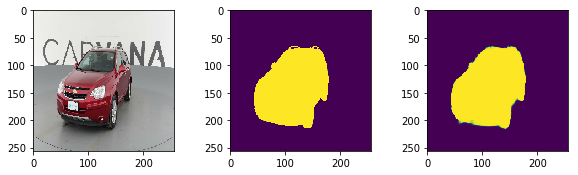

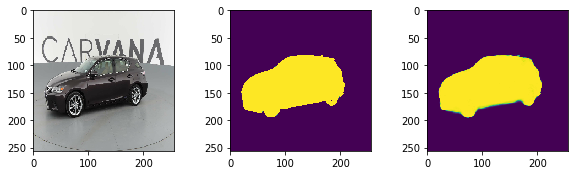

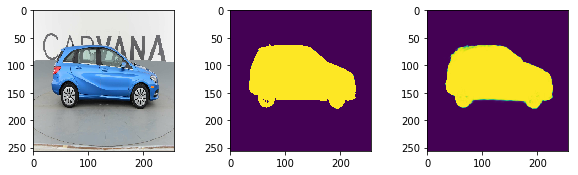

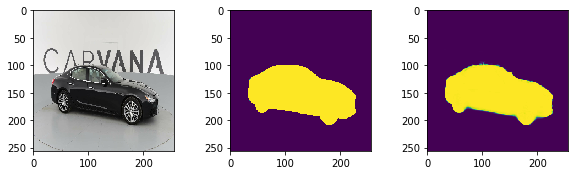

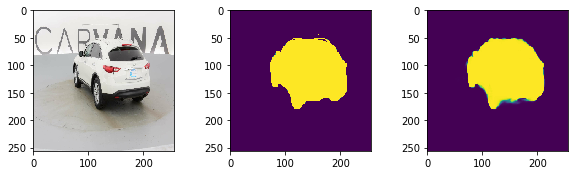

In [51]:
for (i, (img_batch, label_batch)) in enumerate(val_ds.take(5)):
    idx = 2
    img = img_batch[idx]
    label = label_batch[idx]
    label_pred = model(img_batch)[idx]
    
    plt.figure(figsize=(10,15))
    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[:,:,0])
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(label_pred[:,:,0])
plt.show()